
# Lecture 13: Probability III
## Data Science Fundamentals
## Inference and inverse probability
----
 ##### DSF - University of Glasgow - Chris McCaig - 2020/2021

# Summary
By the end of this unit you should know:
* what inference is
* what population, parameters, statistics and samples are
* how parameters can be estimated from a sample
* basic summary statistics: mean, standard deviation
* how to model simple data using normal distributions
* how estimators and maximum likelihood estimation work
* the maximum likelihood algorithm
* what Bayesian inference involves
* MCMC approaches to sampling posteriors in Bayesian inference
* the difference between the posterior and the predictive posterior

In [1]:
import IPython.display
IPython.display.HTML("""
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>""")

$$\newcommand{\vec}[1]{{\bf #1} } 
\newenvironment{examinable}{\hspace{8em}}{{\hspace{8em}\LARGE[\spadesuit]}}
\newcommand{\real}{\mathbb{R}}
\newcommand{\expect}[1]{\mathbb{E}[#1]}
\DeclareMathOperator*{\argmin}{arg\,min}
$$


In [27]:
# !pip install uvloop
# !pip install metropolis
#!pip install pymc3
import numpy as np
import scipy.stats as stats
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
from jhwutils.float_inspector import print_shape_html, print_float, print_float_html
from jhwutils.matrices import show_boxed_tensor_latex, print_matrix
import jhwutils.image_audio as ia
import numpy as np
%matplotlib inline
plt.rc('figure', figsize=(8.0, 4.0), dpi=140, frameon=False)


# Inference

## Population and samples, statistics and parameters
**Inferential statistics** is concerned with estimating the properties of an unobserved "global" **population** of values from a limited set of observed **samples**. This assumes that there is some underlying distribution from which samples are being drawn. This is a hidden process (the "mysterious entity"), which we only partially observe through the samples we see.

<img src="imgs/population.png">

* **Population** is the unknown set of outcomes (which might be infinite)
    * **Example** the weight of all beetles
    * **Parameter** describes this **whole population**, e.g. the mean weight of all beetles
    
* **Sample** is some subset of the population that has been observed.
    * **Example** 20 beetles whose weight has been measured
    * **Statistic** is a function of the sample data, e.g. the arithmetic mean of those 20 samples
    
The parameters of the population distribution govern the generation of the samples that are observed. The problem of statistics is how to **infer** parameters given samples.



<img src="imgs/mysterious.png" width="50%">

*Our old friend; the mysterious entity*

Our model of the world is that there is some unknown entity which **generates** data that we observe, according to some definite but unknown rules. These rules are codified by a **distribution** (a "type" of rule) and **parameters** (the specifics of rules applied). We assume the model has some *randomness* or *stochastic* elements, either because it truly does, or because this makes it simpler to represent the model. 

**Inference** is the process of determining these rules (i.e. the parameters) by looking at the aftermath of the actions of the mysterious entity. These are the **samples** or **observations** that we have. From these we can work out what must have been going on in the mysterious entities world. Or at least approximate it as well as we can. We usually assume that we know or have chosen a specific **distribution** which we expect to be governing the process, and focus on identifying the parameters involved.

<img src="imgs/process_machine_trim.png" width="100%">

## Two worldviews

* **Bayesian inference** means that we consider *parameters* to be random variables that we want to refine a distribution over, and that data are fixed (known, observed data). We talk about belief in particular parameter settings.

* **Frequentist inference** means that we consider *parameters* to be fixed, but data to be random. We talk about how we approach an accurate estimate of the true parameters as our sample size increases.

## Three approaches

We will see three different approaches to doing inference:

* **Direct estimation** of parameters, where we define *functions of observations* that will estimate the values of parameters of distributions *directly*. This requires we assume the form of the distribution governing the mysterious entity. It is very efficient, but only works for very particular kinds of model. We need to have *estimator functions* for each specific distribution we want to estimate, which map observations into parameter estimates. 

* **Maximum likelihood estimation** of parameters, where we use **optimisation** to find parameter settings that make the the observations appear as likely as possible. We can see this as tweaking the parameters of some predefined model until they "best align" with the observations we have. This requires an iterative optimisation process, but it works for any model where the distribution has a known likelihood function (that is we can compute how likely observations were to have been generated by that model).

* **Bayesian, probabilistic** approaches explicitly encode belief about the behaviour of the mysterious entity using probability distributions. In Bayesian models, we assume a distribution over the parameters themselves, and consider the *parameters to be random variables*. We have an initial hypothesis for these parameters ("prior") and we use observations to update this belief to hone our estimate of the parameters to a tighter (hopefully) distribution ("posterior"). Unlike the other methods, we do not estimate a single "parameter setting", but instead we always have a distribution over possible parameters which changes as data is observed. This is much more robust and arguably more coherent way to do inference, but it is harder to represent and harder to compute. We require both **priors** over parameters, and a **likelihood function** that will tell us how likely data is to have been generated under a particular parameter setting.

*Note: there are more general forms of Bayesian inference, like Approximate Bayesian Computation (ABC) which do not even require likelihood functions, just the ability to sample from distributions. We will not discuss these.*





### An inference scenario: The app rating problem

<img src="imgs/appsrating.png"> 
<br><br>*Original [Image](https://flickr.com/photos/smemon/5324223435 "apps") by [Sean MacEntee](https://flickr.com/people/smemon) shared [CC BY](https://creativecommons.org/licenses/by/2.0/)*

You've written an app, and it'll make you rich. If you can make a version that people really like, that is. So maybe you've released a few different beta version to try out some options. Each user has rated the app with 1-5 stars. You need to work out which version is better.

Text(0.5, 1.0, 'Count of ratings for three apps')

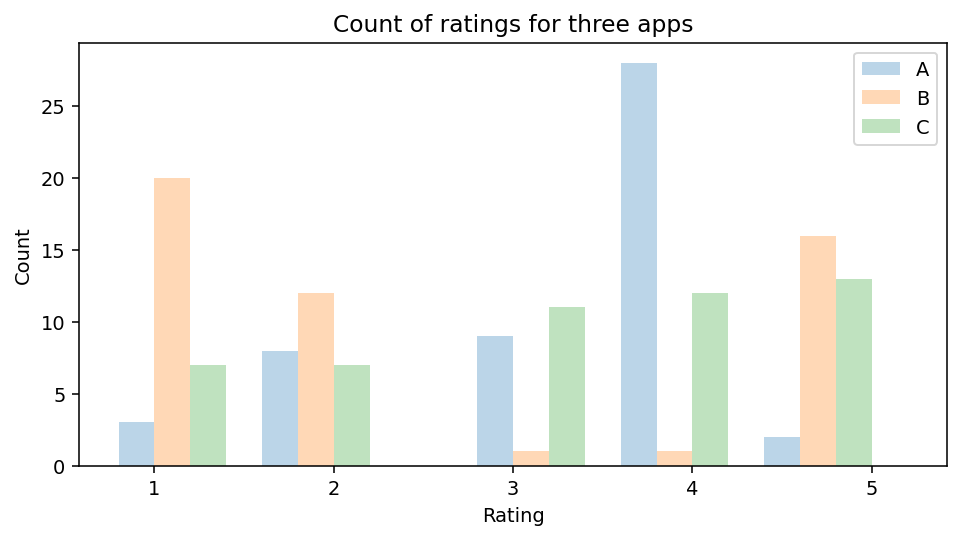

In [3]:
def sample_pmf(ps, n):    
    return np.digitize(np.random.uniform(0,1,n), np.cumsum(ps))
    
app_A = sample_pmf([0.05, 0.2, 0.2, 0.5, 0.05], 50) + 1
app_B = sample_pmf([0.4, 0.125, 0.025, 0.05, 0.4], 50) + 1
app_C = sample_pmf([0.1, 0.2, 0.2, 0.20, 0.30], 50) + 1
apps = [app_A, app_B, app_C]

fig, ax = plt.subplots()
ax.hist(app_A, alpha=0.3, align='left', label="A", width=0.2)
ax.hist(app_B, alpha=0.3, label="B", width=0.2)
ax.hist(app_C, alpha=0.3, align='right', label="C", width=0.2)
ax.legend()
ax.set_xlabel("Rating")
ax.set_ylabel("Count")
ax.set_title("Count of ratings for three apps")

The problem is that you only have a sample of responses. Not every user rated the app, and actually you don't even care about the users who have *already* bought the app and rated it -- you want to know how *prospective* customers will view it, and by definition you cannot have sampled from this population of users.

---

Imagine we are trying to infer the distribution of app scores *assuming that they were generated by a normal distribution*. That is, we imagine there is some function like this:

In [4]:
def app_samples(mu, sigma):
    return np.random.normal(mu, sigma)

This isn't a very good approximation to the real samples; for example, it can generate negative ratings, or ratings with fractional values. It also assumes that all of the ratings that we see are independent of each other (**independence assumption**) and that they are all drawn from the *same* underlying distribution (**identical distribution assumption**).

But it is simple to work with, and the problem we have to solve is: given a collection of return values from this function (samples), what values did `mu` and `sigma` have? 

> This is a problem of inference.

### Estimators
Unlike discrete distributions, where the PMF can be estimated directly from observations using the empirical distribution (as we did for Romeo and Juliet), there is no analogous direct procedure for continuous distributions.

For many continuous distributions statisticians have developed **estimators**; functions that can be applied to sets of observations to estimate the most likely parameters of a probability density function defining a distribution that might have generated them.

The **form** of the distribution must be decided in advance (for example, the assumption that the data has been generated by an approximately normal distribution); this is usually called the **model**. The specific parameters can then be calculated under the assumption of this model.

# Direct estimation

One way of doing inference is to, if we assume a particular *form* of the distribution (e.g. assume it is normal), use **estimators** of **parameters** (such as the mean and variance) of this population distribution. These **estimators** are computed via **statistics** which are summarising functions we can apply to data. *These estimators need to specially derived for each specific kind of problem.*

For example, the arithmetic mean, and the standard deviation of a set of observed samples are **statistics** which are **estimators** of the parameters of $\mu$ and $\sigma$ normal distribution. If we have observations (believed to have been) drawn from a normal distribution, we can estimate the parameters $\mu$ and $\sigma$ of that distribution just by computing the mean and standard deviation.

In other words, we might want to know the "true" average app rating -- the **population mean** of the distribution which is "generating" app ratings. We have an assumption that a random process is creating these ratings, whose operational characteristics (parameters) we can learn from samples. But we can only observe a limited sample of ratings by measuring some specific subset of ratings from users who actually rated the app and computing statistics of the results -- the **sample mean**.  

<img src="imgs/direct_estimation.png" width="50%">

*Image: direct estimation uses a statistic, which is a function of data, to directly estimate parameters; for example, the arithmetic mean of a point cloud estimates the mean vector of the population.*

## Standard estimators

### Mean
The **arithmetic mean** is sum of sample values $x_1, x_2, \dots, x_n$ divided by the number of values:
$$\hat{\mu} = \frac{1}{N} \sum_{i=1}^N x_i$$

### Sample mean
The population mean is $\mu = \expect{X}$ for a random variable $X$. It turns out the *arithmetic mean of the observed samples* or **sample mean**, which we write with a *little hat* $\hat{\mu}$ is a good (footnote: good is what statisticians would call "unbiased") estimator of the true population mean $\mu$. As the number of samples increases, our estimate $\hat{\mu}$ of the population mean $\mu$ gets better and better. 

It's important to separate the idea of
* the population mean $\mu$, which (usually!) exists but is not knowable directly. It is 
the expectation of the random variable $\mathbb{E}[X]$.
* the sample mean $\hat{\mu}$ which is just the arithmetic average of samples we have seen (e.g. computed via `np.mean(x, axis=0)`)

The sample mean is a **statistic** (a function of observations) which is an **estimator** of the population mean (which could be a **parameter** of a distribution). Specific bounds can be put on this estimate; the standard error gives a measure of how close we expect that the arithmetic mean of samples is to the population mean, although the interpretation is not straightforward. 


<img src="imgs/pop_mean.png">

The mean measures the **central tendency** of a collection of values. The **mean vector** generalises this to higher dimensions.

### Variance and standard deviation
The sample variance is the squared difference of each value of a sequence from the mean of  that sequence:

$$\hat{\sigma^2} = \frac{1}{N} \sum_{i=1}^N \left(x_i-\hat{\mu} \right)^2.$$

It is an estimator of the population variance, $\expect{(X-\expect{X})^2}$

The sample standard deviation is just the square root of this value. 

$$\hat{\sigma} = \sqrt{\frac{1}{N} \sum_{i=1}^N \left(x_i-\hat{\mu} \right)^2}$$

The variance and the standard deviation measure the **spread** of a collection of values. The **covariance matrix** $\Sigma$ generalises this idea to higher dimensions.




##### Relation to normal distribution
If we *assume* that our data is generated by a normal distribution, then the statistics **mean** $\hat{\mu}$ and **variance** $\hat{\sigma^2}$  estimate the parameters  $\mu, \sigma$ of that normal distribution, $\mathcal{N}(\mu, \sigma)$. Even if the underlying process isn't exactly normal, it may well be close to being normal because of the Central Limit Theorem. And even if that doesn't apply, the mean and the variance are still useful *descriptive statistics*.


<img src="imgs/convergence_estimate.png">

### Fitting
What does it mean to estimate the parameters of a normal distribution that might be creating app ratings? We are **fitting** a distribution, governed by a PDF, to a set of observations. In our discrete examples, we could fit a distribution simply by computing the empirical distribution (assuming we had enough samples). But estimating a PDF requires some structure, a space of functions with some parameterisation.

We can visualise this:



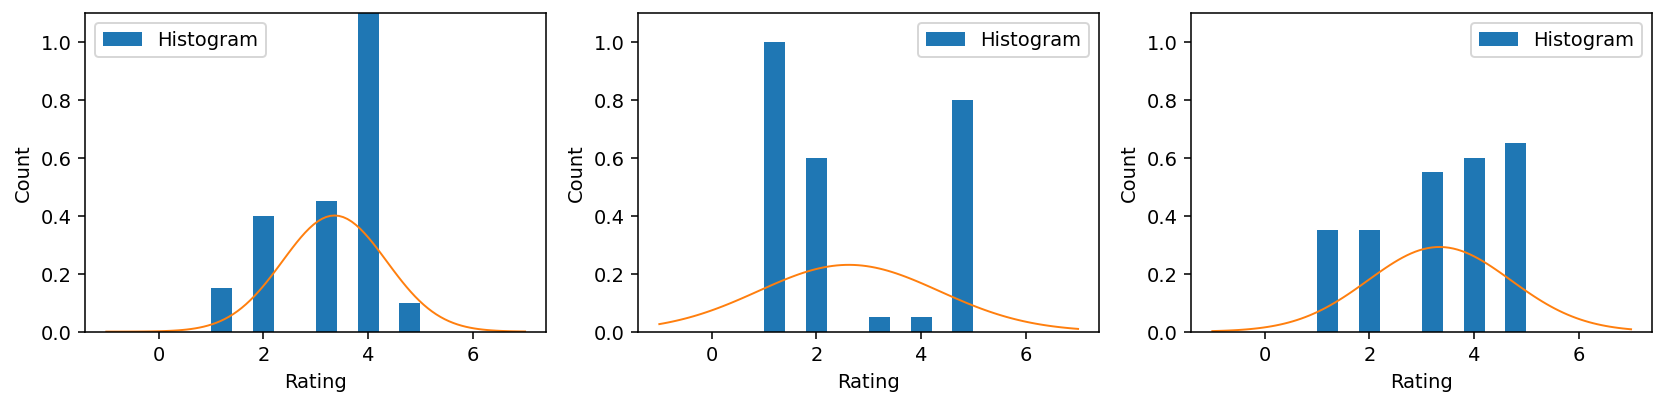

In [28]:

def plot_fits(apps, mus, sigmas, fit_color='C1'):
    fig = plt.figure(figsize=(12,3))

    for i,(app,mu, sigma) in enumerate(zip(apps, mus, sigmas)):
        ax = fig.add_subplot(1,3,i+1)
        
        ax.hist(app, density=True, label="Histogram")    
        xs = np.linspace(-1.0,7.0,100)
        
        # compute the PDF function for this setting of mu and sigma
        for m, s in zip(mu, sigma):
            ax.plot(xs, scipy.stats.norm(m, s).pdf(xs),
                            alpha=1.0/np.sqrt(len(mu)), color=fit_color, lw=1)
            
        # set labeling and axis
        ax.set_ylim(0,1.1)
        ax.set_xlabel("Rating")
        ax.set_ylabel("Count")
        ax.legend()

        plt.tight_layout()
        
apps = [app_A, app_B, app_C]

# use the sample mean, sample standard deviation
plot_fits(apps, [[np.mean(app)] for app in apps], [[np.std(app)] for app in apps])

### Sampling from the model
We can draw samples from our fitted distribution, and compare them to our results. They won't be a very good representation, because the data we have is clearly not normal. But they show what our tame mysterious entity is producing, and let us assess our **modelling assumptions** -- that the app ratings were characterised by just a mean and standard deviation.

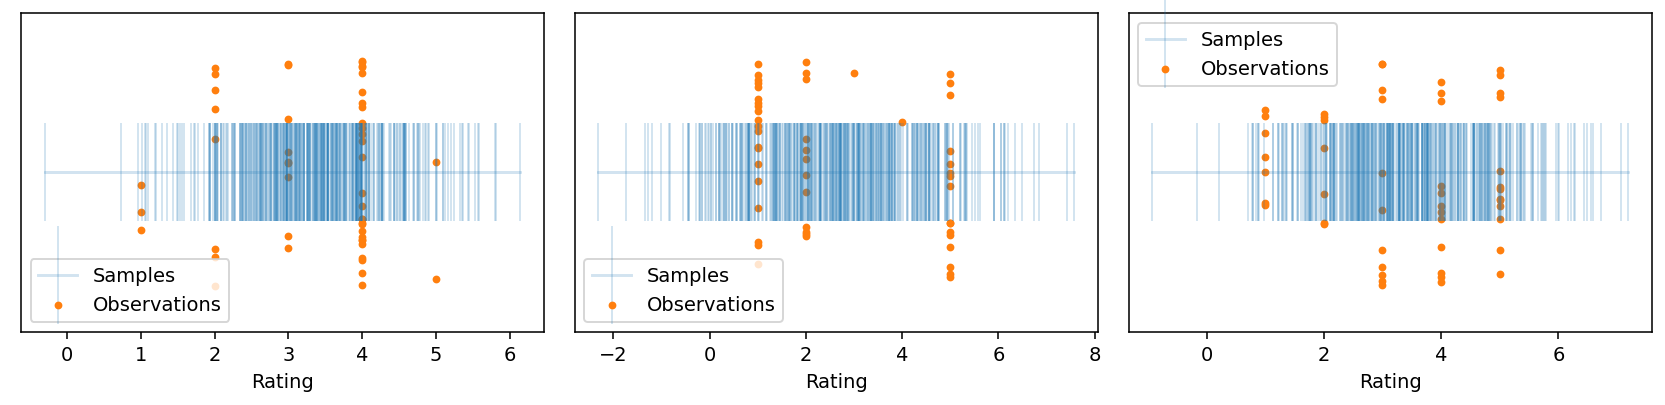

In [6]:

def plot_samples(apps, mus, sigmas, n_samples):
    fig = plt.figure(figsize=(12,3))

    for i,(app,mu, sigma) in enumerate(zip(apps, mus, sigmas)):
        ax = fig.add_subplot(1,3,i+1)
        
        
        ax.scatter(app, np.random.uniform(0,1,app.shape), 
                   marker='.', color='C1', label="Observations")
        
        
        # compute the PDF function for this setting of mu and sigma
        for m, s in zip(mu, sigma):
            samples = np.random.normal(mu, sigma, n_samples)
            ax.plot(samples, samples*0+0.5, marker='|', markersize=50, label="Samples", alpha=0.2)
            
        # set labeling and axis
        ax.set_ylim(-0.2,1.2)
        ax.set_yticks([])
        ax.set_xlabel("Rating")
        
        ax.legend()

        plt.tight_layout()
        

plot_samples(apps, [[np.mean(app)] for app in apps], [[np.std(app)] for app in apps], n_samples=400)

# Maximum likelihood estimation: estimation by optimisation

What if we don't have estimators, ready built to estimate the parameters that we want? How can we do inference? How can we fit distribution parameters to observations?

In many cases, we can compute the **likelihood** of a an observation being generated by a specific underlying random distribution. This is the **likelihood** that we saw earlier. For a PDF, the likelihood of a value $x$ is just the value of the PDF at $x$: $f_X(x)$. The likelihood is a function of the data, under the assumption of some particular parameters. 

The likelihood of many *independent* observations is the product of the individual  likelihoods, and the log-likelihood is the sum of the individual log-likelihoods.

$$\log \mathcal{L}(x_1, \dots, x_n) = \sum_i \log f_X(x_i)$$

Imagine we have a distribution which we *don't* know any **estimators** for the parameters. How could we estimate what they might be, given some data? We could write all of our parameters as vector $\theta$; for example a normal distribution would have $\theta = [\mu, \sigma]$.

<img src="imgs/mle.png" width="50%">

*Image: Maximum likelihood estimation uses optimisation to maximise the likelihood function of the data and find the optimal value of the parameters given the data. It does not require a special estimator function; just a likelihood.*

## Optimisation solves all problems
Even though we don't have a fixed, closed form function to estimate the parameters, with a likelihood function we can apply optimisation to work out a parameter setting under which the data we *actually* observed was most likely. This corresponds to twiddling the knobs on our "mysterious entity" machine, until we find one that outputs the largest likelihood values when we feed in samples to it.

If the likelihood depends on some parameters of a distribution $\theta$, then we write:

$$\mathcal{L}(\theta | x)$$

Then, we could define an **objective function**; to maximise the log-likelihood, or equivalently to minimise the negative log-likelihood.

$$\theta^* = \argmin_\theta L(\theta)$$
$$L(\theta) = -\log \mathcal{L}(\theta | x_1, \dots, x_n) = -\sum_i \log f_X(x_i;\theta) , $$

assuming our $f_X(x_i)$ can be written as $f(x;\theta)$ to represent the PDF of $f$ with some specific choice of parameters given by $\theta$.

### Maximum likelihood estimation
This is *very* similar to the approximation objective function we saw before $\|f(\vec{x};\theta)-y\|$, but we have $y=0$ and we only have a scalar output from $f$ so the norm is unnecessary. We already know how to solve this kind of problem; just optimise. This is called **maximum likelihood estimation** and is a general technique for determining parameters of a distribution which we don't know given some observations. It will find the **best** setting of parameters that would explain how the observations came to be.

If we're lucky, this will be differentiable and we can use gradient descent (or stochastic gradient descent -- note that the objective function is a sum of simple sub-objective functions). If we're not, we can fall back to less efficient optimisers. We don't need special estimators in this case, as long as we can evaluate the PDF $f(x;\theta)$ for any setting of parameters $\theta$. *This works for a much wider class of probability distributions*.

### Fitting a normal with MLE

We can for example look at the problem of estimating the mean and variance of a normal distribution from a set of (assumed to be independent) samples *without* using estimators; for example our app ratings. To do this, we need to be able to compute the likelihood for any given sample, and take the product (or rather sum of log likelihoods) for all of those samples. 

This gives us our objective function. If we flip the sign, so that we minimise the negative log-likelihood, we will then search for the parameter vector that makes the data most likely. 

For a univariate normal distribution, the parameters are just $\mu$ and $\sigma$, so $\theta=[\mu, \sigma]$.

In this case, of course, we *do* have estimators; but the procedure works just as well when we only have a likelihood function.

In [7]:
import scipy.stats
import scipy.optimize

# our data on the app ratings
apps = [app_A, app_B, app_C]

def loglik_norm(data, theta):
    # compute log-likelihood of observations
    # how likely is this data *under the assumption*
    # that these parameters are set
    return -np.sum(scipy.stats.norm(theta[0], 
                                    np.abs(theta[1])).logpdf(data))

thetas = []
for app,name in zip(apps, "ABC"):
    print("MLE estimate for app {app}".format(app=name))
    
    
    # compute the log-likelihood for this specific dataset
    loglik = lambda theta, data=app: loglik_norm(data, theta)    
    # MLE optimise
    theta = scipy.optimize.minimize(loglik, 
                                    [1.0, 1.0],
                                    tol=1e-5).x
    thetas.append(theta)
    print("Sample statistics for app {app}".format(app=name))
    print(theta)
    # compare with using the direct estimates of these parameters
    print(np.mean(app), np.std(app))
    print()    

MLE estimate for app A
Sample statistics for app A
[3.35999999 0.9951885 ]
3.36 0.9951884243699783

MLE estimate for app B
Sample statistics for app B
[2.62000001 1.7307802 ]
2.62 1.730780170905595

MLE estimate for app C
Sample statistics for app C
[3.34000024 1.36543035]
3.34 1.3654303350958628



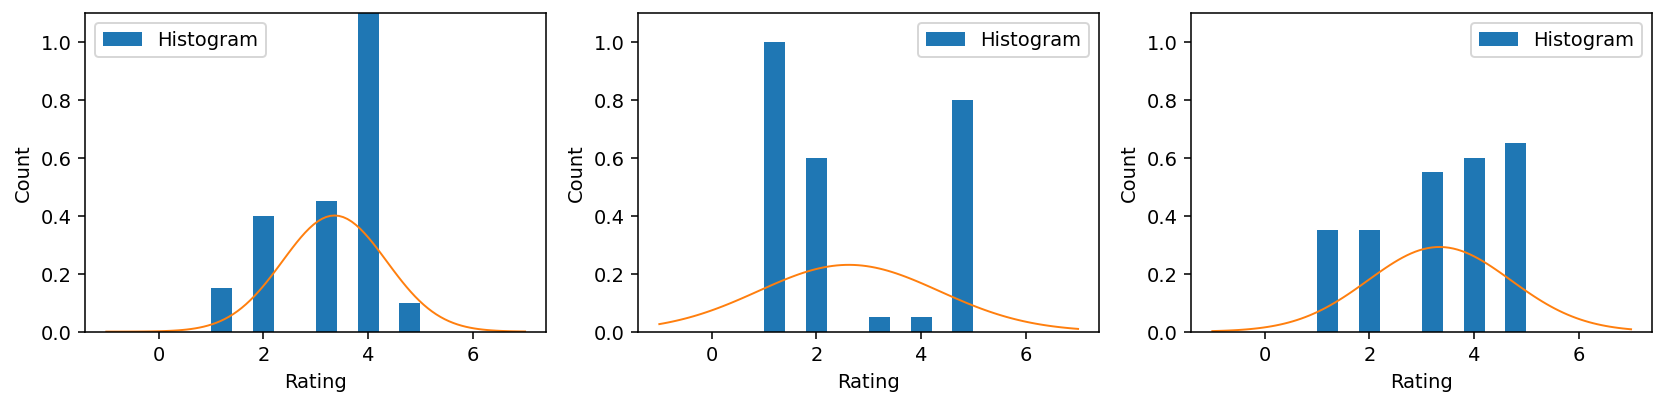

In [8]:
# use the sample mean, sample standard deviation
plot_fits(apps, [[np.mean(app)] for app in apps], [[np.std(app)] for app in apps])

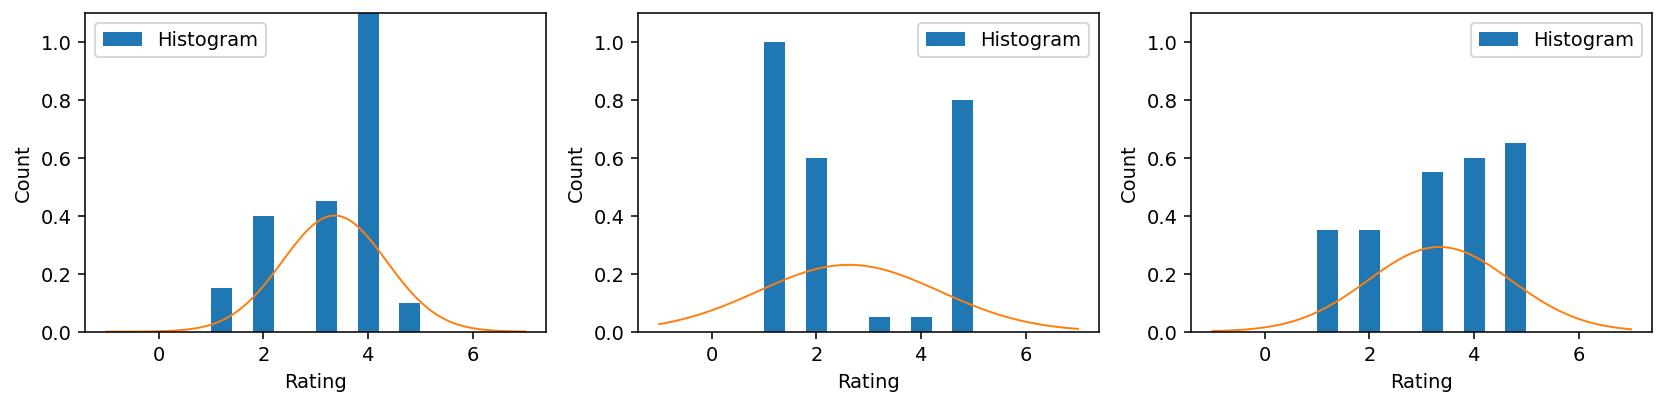

In [9]:
# Use the MLE fit, which should look exactly the same (within some tiny tolerance)
plot_fits(apps, [[theta[0]] for theta in thetas], [[theta[1]] for theta in thetas])

### A mixture model

But what if our model was more complicated that just a normal distribution? We could imagine that we model in some other way, perhaps that might be able to capture the fact that app B seems to have two "humps" on either side. One very simple model is a **mixture of Gaussians**, where we just say that we expect the PDF of the distribution we are trying to fit is a weighted combination (convex sum) of $N$ different normal distributions ("components") $\mathcal{N_i}(\mu_i, \sigma_i)$, each with its *own* $\mu_i, \sigma_i$, and with a weighting factor $\lambda_i$ that says how important this "component" is, where $\sum_i \lambda_i=1$. This lets us represent "humpy distributions.

This model lets us imagine that ratings might belong to one "cluster" or another. The placement and size of each cluster is given by the $\mu_i$ and $\sigma_i$ for that component and $\lambda_i$ gives an idea of how likely data is to fall into that cluster.

We can easily plot the PDF of this function; it's just:
$$f_X(x) = \sum_i \lambda_i n_X(x; \mu_i, \sigma_i),$$ where $n_X(x; \mu,\sigma) = \frac{1}{Z} e^{\frac{(x-mu_i)^2}{2\sigma^2}}$ is the standard normal PDF function.

In [10]:
def pdf_mixture(mus, sigmas, lambdas):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    xs = np.linspace(-4,4,100)
    pdf = np.zeros_like(xs)
    
    # compute the PDF of each component, weighted by
    # the corresponding lambda
    for mu, sigma, l in zip(mus, sigmas, lambdas):
        # sum of pdfs
        sub_pdf = scipy.stats.norm(mu, sigma).pdf(xs) * l
        pdf += sub_pdf
        ax.plot(xs, sub_pdf)
        
    # plot the sum PDF
    ax.plot(xs, pdf, lw=3, label="Mixture PDF")
    ax.legend()
    ax.set_xlabel("$x$")
    ax.set_ylabel("$f_X(x)$")

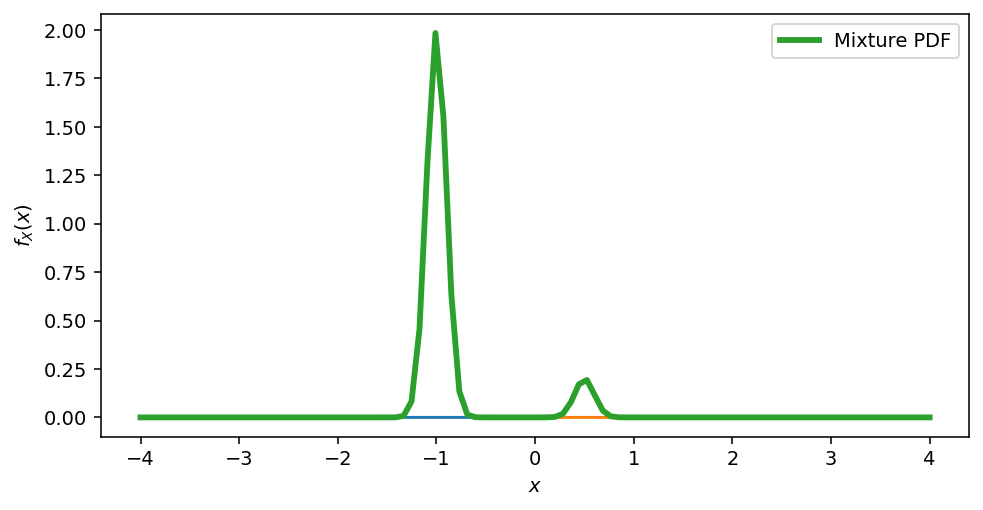

In [11]:

# N = 2
pdf_mixture([0.5, -1], [0.1, 0.1], [0.05, 0.5])
 

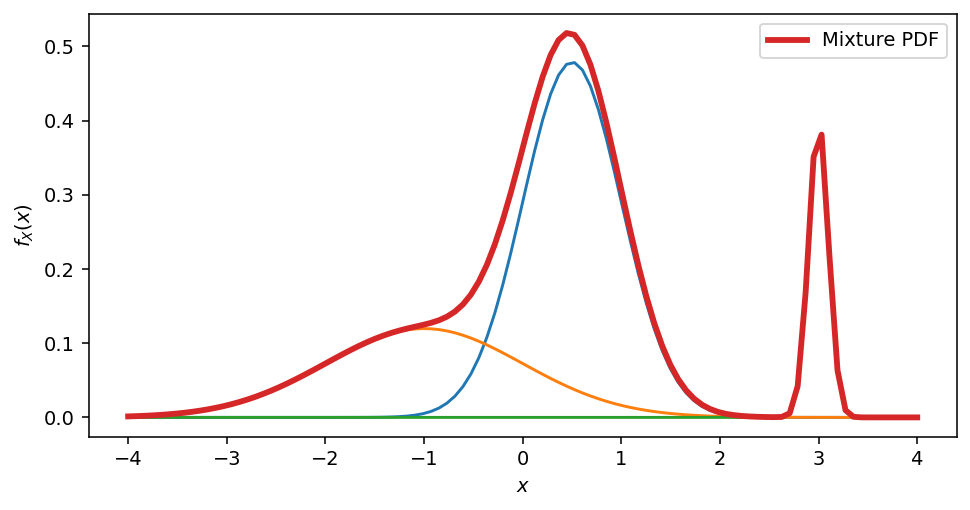

In [12]:
# N = 3
pdf_mixture([0.5, -1, 3], 
            [0.5, 1.0, 0.1], 
            [0.6, 0.3, 0.1])

### Fitting mixtures
This is a much more plausible model of our app ratings, and might be a much better model. But how do we fit it? Even if we fix $N$ in advance, we definitely don't have any direct estimators that can estimate the mean and standard deviation (and weighting) of a sum of normal PDFs. This simply isn't something we know how to do. 

**But** the (log) likelihood is trivial to write in code. For each observation $x$, we just compute the sum of the weighted PDFs for 
each component, and the result is likelihood for that observation. This is a function of the data $\mathcal{L}(\theta|x)$ , and our parameter vector is $\theta = [\mu_1, \sigma_1, \lambda_1, \mu_2, \sigma_2, \lambda_2, \dots]$.


In [13]:
def pdf_mixture(xs, mus, sigmas, lambdas):    
    return sum([scipy.stats.norm(mu, sigma).
                pdf(xs) * l 
               for mu,sigma,l in 
                zip(mus, sigmas, lambdas)])
    
# log likelihood of the mixture PDF    
def llik_pdf_mixture(xs, mus, sigmas, lambdas):        
    return np.sum(np.log(pdf_mixture(xs, mus, sigmas, lambdas)))



This means we can also fit it with maximum likelihood. We do not require an explicit estimator for the parameters; we can just optimise. In this case, we fix $N$ to 2, and then find the parameters that best fit the data. This is a point in the vector space $\real^6$; we need three parameters $\mu_i,\sigma_i,\lambda_i$ for each component $i$.

In [14]:
# our data on the app ratings
apps = [app_A, app_B, app_C]

def theta_to_params(theta):
    # remap our vector into three parameters
    # forcing lambdas to add to one
    # and sigma to be positive, and not
    # ridiculously small
    mus, sigmas, lambdas = theta.reshape(-1,3).T       
    # force lambda to normalise to 1 (and be positive)
    lambdas = np.abs(lambdas) 
    lambdas = lambdas / np.sum(lambdas)
    # force sigma not to collapse to 0
    # or be negative
    return mus, np.exp(sigmas)+0.2, lambdas

def loglik_mixture(data, theta):
    # compute log-likelihood of observations
    # how likely is this data *under the assumption*
    # that these parameters are set
    mus, sigmas, lambdas = theta_to_params(theta)
    r = -llik_pdf_mixture(data, mus, sigmas, lambdas)  
    
    return r

In [15]:
# we can even do this with differnt numbers of components
# without changing the rest of the code
init_theta = [1.0, 1, 0.25, 
              5.0, 1, 0.25,
              2.5, 2, 0.25,
              8.5, 2, 0.25], 
                                      

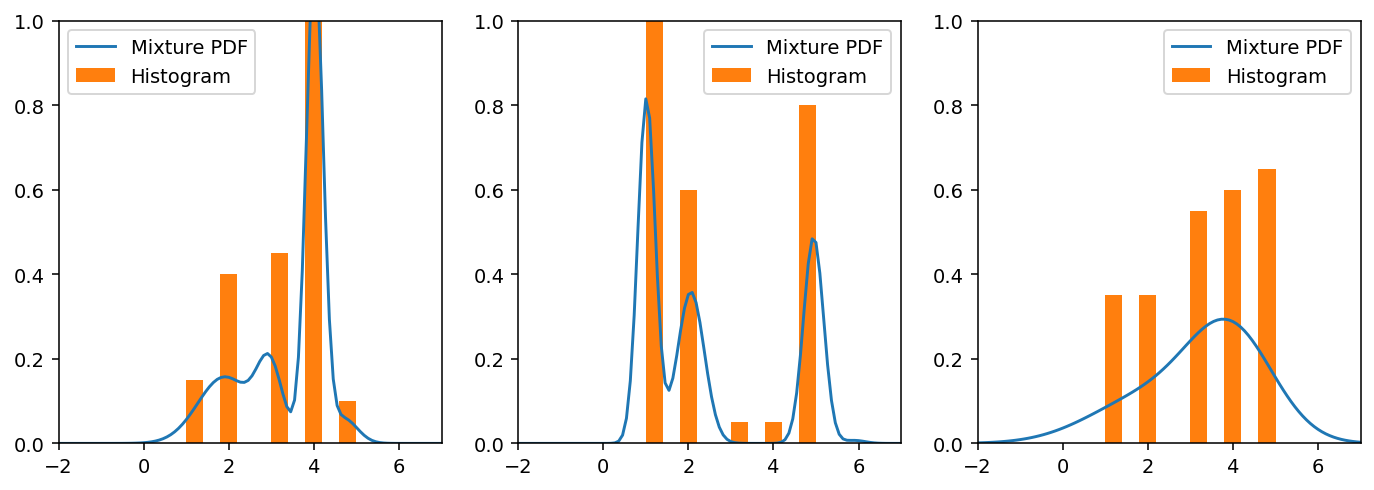

In [16]:
###############
fig = plt.figure(figsize=(12,4))

# iniital guess for parameters
#            mu log(sigma) lambda
#init_theta =[1.0,  1,     0.5, 
#            5.0,   1,     0.5]

for i,(app,name) in enumerate(zip(apps, "ABC")):
    
    
    loglik = lambda x, y=app: loglik_mixture(y, x)
    
    # assume we have 2 components, so we must specify
    # an initial guess for mu, sigma and lambda
    # for each of these; this is six numbers
    # MLE optimise
    np.random.seed(2018)
    theta = scipy.optimize.minimize(loglik, init_theta, 
                                    tol=1e-5, 
                                   method='TNC').x

    
    mus, sigmas, lambdas = theta_to_params(theta)
    
    # plot the results
    ax = fig.add_subplot(1,3,i+1)
    xs = np.linspace(-2, 7, 100)
    # compute the PDF curve
    pdf = pdf_mixture(xs, mus, sigmas, lambdas)    
    ax.plot(xs, pdf, label="Mixture PDF")    
    ax.hist(app,  density=True, label="Histogram")
    ax.set_ylim(0,1)
    ax.set_xlim(-2,7)
    ax.legend()

---

# Bayesian Inference

Bayesian inference involves thinking about the problem quite differently. Bayesians represent the *parameters* of the distribution they are estimating as random variables *themselves*, with distributions of their own. 

Prior distributions are defined over these parameters (e.g. we might believe that the mean app rating could be any value 1.0-5.0 with equal probability) and evidence arriving as updates is combined using Bayes' Rule to refine our belief about the distribution of the parameters. We again consider our distribution to be characterised by some parameter vector $\theta$ and we want to refine a distribution over possible $\theta$s.

We don't think about estimators, or their sampling distributions, and it doesn't make sense to talk about finding the best parameter setting; we can only have *beliefs* in parameter settings which must be represented probabilistically. We do not seek to find the most likely parameter setting (as in direct estimation or MLE), but to infer a distribution over possible parameter settings *compatible with the data*. 

We talk about inferring a **posterior** distribution over the parameters, given some **prior** belief and some **evidence**. We assume that we have a **likelihood function** $P(D|\theta)$, and a prior over parameters $P(\theta)$ and we can then use Bayes Rule in the form:

$$
P(\theta|D) = \frac{P(D|\theta) P(\theta)}{P(D)}
$$

which gives us a new distribution over $\theta$ given some observations. Bayes' rule applies just as well to continuous distributions as to discrete ones, but computations in "closed form" (i.e. algebraically) are much harder. 

<img src="imgs/bayesian_inference.png">

This *can* be done in closed form to find $P(\theta|D)$ in certain cases, but the algebra is often complex and the model choices are limited; we will not discuss how to do this. When it is possible, it is, however, much more computationally efficient. Instead we will approach this from a computational perspective and find a way to draw *samples* from the posterior distribution $P(\theta|D)$.

## Example

Remember, we are assuming that app ratings are generated by this function:

In [17]:
def app_samples(mu, sigma):
    return np.random.normal(mu, sigma)

We want to *infer a distribution* over $\mu$ and $\sigma$ (**NOT** a distribution over the observations!). That is, we will treat the parameters themselves as random variables, with their own distributions, and use Bayesian reasoning (i.e. applying Bayes Rule) to infer a posterior distribution over the parameters given some prior, and some evidence observed.

### Parameters and samples
We have a collection of observations $D=x_1, x_2, \dots$, which represent actual app ratings.  We're not sure how much those ratings really tell us about the unseen population of potential users. We represent the distribution parameters as $\theta = [\mu, \sigma]$, and can talk about $P(\theta)$, a distribution over the parameter vectors.

### Priors
Assume we have some prior belief $\theta$, $P(\theta)$: for example this might be a very simple assumption that our prior is that $\mu$ and $\sigma$ are uniformly distributed

* $\mu \sim U(1,5)$
* $\sigma \sim U(0, 10)$

This gives us a form for $P(\theta)$. We could write a way of sampling from this distribution in code, and a way of evaluating the prior probability of any given parameter setting. As we will see later, we will need both of these functions to do Bayesian inference.

In [18]:
def sample_prior():
    return [np.random.uniform(1,5), 
            np.random.uniform(0,3)]

def log_prior(theta):
    mu, sigma = theta    
    # p(x) = 1/x if x ~ U(0,x), and 0 otherwise
    return (scipy.stats.uniform(1.0, 4.0).logpdf(mu) + 
            scipy.stats.uniform(0.0, 3.0).logpdf(sigma))
    

In [19]:
log_prior([1.5, 0.3])

### Likelihood

We need to be able to define a **likelihood function**. This is a function of data given some parameter setting, and in this case it is the same as the likelihood function used for MLE: the likelihood of one sample is just the normal PDF evaluated at that point, and the likelihood of all samples is the product of these likelihoods.


In [20]:
def log_likelihood(samples, theta):
    # for a *known* mu, theta
    # compute the log PDF at each sample, and sum them
    return np.sum(scipy.stats.norm(theta[0], 
                                   theta[1]).logpdf(samples))    

Note carefully: in many cases we can only evaluate this likelihood function directly for a *specific* setting of $\theta$; but we have a **distribution** over $\theta$ to deal with when doing Bayesian inference. 

## Inference

How can we compute the posterior distribution $P(\theta|D)$? We won't discuss how to find this in closed form (as a function) -- this is sometimes possible, but mathematically involved because we need to deal with distributions over $\theta$ -- but rather how to draw samples from this posterior, given a prior and a likelihood and some observations. 

There is a huge literature on how to solve this problem, which has a few nasty parts:
* $P(D|\theta)$ needs to be computed for a **distribution** over $\theta$, not just some numbers. It's no good to just compute the probability for one specific $\theta$; we have to work with distribution functions.
* $P(D) = \int_\theta P(D|\theta)P(\theta)$ which is likely intractable.

### Making it tractable

There are lots of ways this can be simplified to make it possible to solve. We are going to use two:

#### Samples will do
We often can't compute $P(\theta|D)$ because we don't know how to do operations on products of functions. But it's often trivial for *specific, concrete* values of $\theta$. For example, for a given fixed $\theta$ we can compute both the likelihood and the prior of that specific example.

This leads us to the idea of **drawing samples** from the posterior distribution $P(\theta|D)$, instead of trying to compute the distribution exactly. 

#### Relative probability only
We can make a simplifying assumption: we only care about the *relative* probability of different parameter settings with the data that we actually have, $D$. That is we have

$$P(\theta|D) \propto P(D|\theta)P(\theta)$$ and ignore the fact that this is the posterior scaled by some unknown constant  $Z=\frac{1}{P(D)}$. This only makes sense because we are only considering one model with one set of data in this example.


# Markov Chain Monte Carlo
We can implement a procedure to sample from the (relative) posterior distribution via a very simple modification of the *simulated annealing* algorithm. 

This defines a random walk through the space of parameter settings, proposing small random tweaks to the parameter settings, and accepting "jumps" if they make the estimate more likely, or with a probability proportional to the change in $P(D|\theta)P(\theta)$ if not. The advantage of this approach is that we can work with *definite samples* from $\theta$ and we don't have to do any tricky integrals. This approach is called **Markov Chain Monte Carlo**

All we require is a way of evaluating $P(\theta)$ (prior) and $P(D|\theta)$ (likelihood) for any specific $\theta$.

## MCMC in practice: sampling issues

We will use Markov Chain Monte Carlo to solve the Bayesian inference problem. The **great thing** about MCMC approaches is that you can basically write down your model and then run inference directly. There is no need to derive complex approximations, or to restrict ourselves to limited models for which we can compute answers analytically. Essentially, no maths by hand; everything is done algorithmically.

MCMC allows us to draw samples from any distribution $P(X=x)$ *that we can't sample from directly*. In particular, we will be able to sample from the posterior distribution over parameters.  

The **bad thing** about MCMC approaches is that, even though it will do the "right thing" *asymptotically*, the choice of sampling strategy has a very large influence for the kind of sample runs that are practical to execute. Bayesian inference should depend only on the priors and the evidence observed; but MCMC approaches also depend on the sampling strategy used to approximate the posterior. 

### What distribution are we sampling from?
In the case of Bayesian inference $P(\theta|D) = \frac{P(D|\theta)P(\theta)}{P(D)} = \frac{P(D|\theta)P(\theta)}{\int_\theta P(D|\theta)P(\theta)}$. 
* $P(\theta|D)$ is the posterior, the distribution over the parameters $\theta$ given the data (observations) $D$, using:
* the likelihood $P(D|\theta)$, 
* prior $P(\theta)$ and 
* evidence $P(D)$. 

In other words, what is the distribution over the parameters given the observations and the prior? If we assume, as above, that we don't care about $P(D)$, because we are only comparing different possible values of $\theta$ then we can draw samples from a distribution proportional to $P(D|\theta)P(\theta)$.

### Metropolis-Hastings
Metropolis-Hastings (or just plain Metropolis) is a wonderfully elegant and relatively effective way of doing this MCMC algorithm, and is able to work in high-dimensional spaces (i.e. when $\theta$ is complicated). 

Metropolis sampling uses a simple auxiliary distribution called the **proposal distribution** $Q(\theta^\prime|\theta)$ to help draw samples from an intractable posterior distribution $P(\theta|D)$. This is analogous to what we called the **neighbourhood function** in the optimisation section.

Metropolis-Hastings uses this to **wander around** in the distribution space, accepting jumps to new positions using $Q(\theta^\prime|\theta)$ to randomly sample the space of $P(\theta|D)$.  This random walk (a **Markov chain**, because we make a random jump conditioned only on where we currently are) is a the "Markov Chain" bit of "Markov Chain Monte Carlo".

This is just like the simulated annealing algorithm, except now there is a function $f_X(\theta)$ which makes some steps more likely than others instead of a likelihood function. We just take our current position $\theta$, and propose a new position $\theta^\prime$, that is a random sample drawn from $Q(\theta^\prime|\theta)$. Often this is something very simple like a normal distribution with mean $x$ and some preset $\sigma$: $Q(\theta^\prime|\theta) = \mathcal{N}(\theta, \sigma^\prime)$

We can show a simple demo of this, drawing samples from a tricky 2D probability distribution.
<img src="imgs/mcmc.png">

## Trace
The history of accepted samples of an MCMC process is called the **trace**. We can estimate model parameters by looking at the histogram of the **trace**, for example. The trace is the sequence of samples $[x^{(1)}, x^{(2)}, x^{(3)}, \dots x^{(n)}]$, (approximately) drawn from the **posterior** distribution $P(\theta|D)$ via MCMC.



## Predictive posterior: sampling from the model
What we have plotted is samples from the **posterior distribution of the model parameters**; i.e. the values we expect the model parameters to take on given the data we observed and our prior.

The **predictive posterior** is the *distribution over observations* we would expect to see; predictions of future samples. This means drawing samples from the model, while integrating over parameters from the posterior. By sampling from the predictive posterior, we are generating new synthetic data that should have the same statistical properties as the data (if our model is good).

We can do this with a two step, nested process:

* for $n$ repetitions
* draw samples from our posterior distribution over parameters to give us a concrete distribution
    * for $m$ repetitions
        * draw samples from this concrete distribution


# Inference: a review


## Linear regression

**Linear regression** is the fitting of a line to observed data. It assumes the mysterious entity generates data where one of the observed variables is scaled and shifted version of another observed variable, corrupted by some noise; a linear relationship. It is a very helpful lens through which different approaches to data modelling can be seen; it is pretty much the simplest useful model of data with relationships, and the techniques we use easily generalise from linear models to more powerful representations.

The problems is to estimate what that scaling and shifting is. In a simple 2D case, this is the gradient $m$ and offset $c$ in the equation $y=mx+c$. It can be directly generalised to higher dimensions to find $A$ and $\vec{b}$ in $$\vec{y}= A\vec{x} + \vec{b},$$ but we'll use the simple "high school" $y=mx+c$ case for simplicity.

We assume that we will fit a line to *noisy* data. That is the process that we assume that is generating the data is $$y=mx+c+\epsilon,$$ where $\epsilon$ is some noise term. We have to make assumptions about the distribution of $\epsilon$ in order to make inferences about the parameters.

One simple assumption is that $$\epsilon \sim \mathcal{N}(0, \sigma^2),$$ i.e. that we have normally distributed variations in our measurements. So our full equation is:

$$y=mx+c+\mathcal{N}(0, \sigma^2),$$

or equivalently, putting the $mx+c$ as the mean of the normal distribution:

$$y \sim \mathcal{N}(mx+c, \sigma^2)$$

Note that we assume that $y$ is a random variable, $x$ is known, and that $m, c, \sigma$ are parameters that we wish to infer from a collection of observations:

$$[(x_1, y_1),\\ (x_2, y_2),\\ \dots,\\ (x_n, y_n)]$$

In code, we could write down what we *assume* is generating data, our tame mysterious entity:

In [31]:
def model(x, theta):
    m, c, sigma = theta
    y =  np.random.normal(x * m + c, sigma)
    return y

Our problem is: given just the inputs $x$ and return values $y$, what are the values of the *other* argument $\theta$.

### Linear regression via direct optimisation
We saw how this problem could be solved as a **function approximation** problem using optimisation. We can write an objective function:

$$L(\theta) = \|f(x;\theta)-y\|, $$ where $\theta=[m,c]$ and $$f(x;\theta) = \theta_0 x + \theta_1$$. 

If we choose the squared Euclidean norm, then we have, for the simple $y=mx+c$ case :

$$L(\theta) = \|f(x;\theta)-y\|$$
$$L(\theta) = \|\theta_0 x + \theta_1 - y\|^2_2 = (\theta_0 x + \theta_1 - y)^2, $$

which we can easily minimise, e.g. by gradient descent, since computing $\nabla L(\theta)$ turns out to be easy.  This is **ordinary linear least-squares**.

<img src="imgs/linear_lsqr.png">

*Linear least squares tried to make the size of the squares nestled between the line and data points as small as possible*

In fact, we can find a closed form solution to this problem, without doing any iterative optimisation. This is because we have an **estimator** that gives us an estimate of the parameters of the line fit directly from observations. We can derive this, for example, by setting $\nabla L(\theta)=0$ and solving directly (high-school optimisation).

### Linear regression via maximum likelihood estimation
We could also consider this to be a problem of inference. We could explicitly assume that we are observing samples from a distribution whose parameters we wish to estimate. This is a **maximum likelihood approach**. This requires that we can write down the problem in terms of the distribution of random variables.

If we assume that "errors" are normally distributed values which are corrupting a perfect $y=mx+c$ relationship, we might have a model $Y \sim \mathcal{N}(mx+c, \sigma^2)$; $Y$ has mean $mx+c$ and some standard deviation $\sigma$. 

We can write this as a maximum likelihood problem (MLE), where we maximise $\mathcal{L}(\theta|x_1, y_1, x_2,y_2, \dots, x_n, y_n)$. To avoid underflow, we work with the log of the likelihood and minimise the negative log-likelihood. The log-likelihood of  independent samples $x_i$  is given by:

$$\log \mathcal{L}(\theta|x_1, y_1,  \dots, x_n, y_n) = \log \prod_i f_Y(x_i, y_i) = \sum_i \log f_Y(x_i, y_i), $$

$$f_Y(x_i, y_i) = \frac{1}{Z}\, e^{-\frac{(y_i - \mu)^2}{2 \sigma^2}}, \quad \mu = mx_i+c$$

We can then minimise the negative log-likelihood to find the "most likely" setting for $\theta=[m,c,\sigma]$, which (if we feel like writing out long equations in LaTeX), we could write as an objective function:

$$L(\theta) = -\sum_i \log \left[ \frac{1}{Z}\, e^{-\frac{(y_i - \theta_0 x_i + \theta_1)^2}{2 \theta_2^2}} \right],$$

In the case where we have normally distributed noise for linear regression, this turns out to be *exactly* equivalent to the direct optimisation with linear least-squares, although we will also find the standard deviation of the error $\sigma$ in addition to $m$ and $c$. This is **maximum likelihood linear regression**.

*[Note: you definitely do not need to remember these equations or be able to derive them. You should understand the logic behind them, however].*

<img src="imgs/mle_linear.png">

*Maximum likelihood estimation tried to find parameters of a line that made the observations likely*

### Bayesian linear regression 
What if we wanted to know how sure our estimates of $m$ and $c$ (and $\sigma$) were? MLE will tell us the *most likely setting*, but it won't tell us the possible settings that are compatible with the data.

The Bayesian approach is to let the parameters themselves by random variables. We don't want to optimise. We don't want to find the most likely parameters. We instead want to derive a belief about the parameters as a probability distribution. This is what Bayesians do; they represent belief with probability.

So we can write $\theta = [m,c,\sigma]$ as a random variable, and try and infer the distribution over it. We can do this using Bayes' rule.  Writing in the form ($D$=data, $H$=hypothesis; hypothesised parameter settings):

$$P(H|D) = \frac{P(D|H) P(H)}{P(D)}$$

Assuming our hypotheses $H$ are parameterised by $\theta$, then we want to know $P(\theta|D) = \frac{P(D|\theta)P(\theta)}{P(D)}$, where $D$ stands for the data $[(x_1, y_1), (x_2, y_2), \dots, (x_n, y_n)]$. In linear regression $\theta$ can be seen as the hypothesis that the data was generated by a line with parameters specified by $\theta$.

We need:
* a **prior** over the parameters $P(\theta$). An initial belief about the possible gradient $m$, offset $c$ and noise level $\sigma$, in the linear regression case.
* a way of calculating the **likelihood** $P(D|\theta)$. 
* a way of combining these using Bayes Rule. In general this is impossible to compute exactly (in particular the $P(D)$ term is often intractable), but we could sample from it using **Markov Chain Monte Carlo**, for example.

This will give us samples from the posterior distribution of $P(\theta|D)$, so we can see how sure we should be about our beliefs about the parameters of the mysterious entity.

<img src="imgs/bayesian_linear.png">

*Bayesian regression tries to update a distribution over line parameters given evidence*


## Summary of terms
* **Parameters** variables that affect a random process
* **Prior** belief about parameters before observing
* **Observations** samples from a process we have seen
* **Posterior** belief about parameters after seeing observations 
* **Predictive posterior** belief about observations we would see, given the posterior we have inferred.


## Resources
* **Bayesian methods for Hackers** https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers (a full "book" on Bayesian methods and inference)
* [**MCMC for dummies**](http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/)
* [**Bayesian Linear Regression**](https://www.chrisstucchio.com/blog/2017/bayesian_linear_regression.html) 